In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from notebooks.utils import load_sample, model2prompt_cost, model2output_cost, model2prompt_length, model2output_length

from typing import List
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

interpolation_num = 20
bon = 5
method2color = {
    'Matrix-of-Router': 'tab:red',
}

In [2]:
model_name_list = ['gpt-4o', 'gpt-35-turbo', 'phi-3-mini', 'phi-3-medium', 'mistral-7b', 'mistral-8x7b', 'llama-31-8b', 'codestral-22b']
model2est_cost = {}
for model_name in model_name_list:
    model2est_cost[model_name] = model2prompt_cost[model_name] * model2prompt_length[model_name] + model2output_cost[model_name] * model2output_length[model_name]

In [3]:
def plot_matrix_of_router(
    labels: torch.Tensor,
    predictions: torch.Tensor,
    costs: List[List[float]],
):
    """
    Plots the cost versus error for a given set of labels and predictions.

    Parameters:
    - labels (torch.Tensor): The labels.
    - predictions (torch.Tensor): The predicted logits.
    - costs (List[List[float]]): The estimated costs.

    Returns:
    None
    """
    t_scores = []
    t_cost = []

    new_preds = torch.transpose(torch.softmax(torch.tensor(predictions, dtype=torch.float32), dim=-1), 0, 1)
    new_labels = labels
    new_preds = [[(_[0] - _[1]).tolist() for _ in preds] + [1] for preds in new_preds]
        
    min_p_diff = np.min(new_preds)
    max_p_diff = np.max(new_preds)

    for i in range(interpolation_num + 1):
        t = min_p_diff + (max_p_diff - min_p_diff) * i / interpolation_num
        scores_list = []
        cost_list = []
        for c, p, l in zip(costs, new_preds, new_labels):
            # select the model with the lowest cost that satisfies the threshold
            try:
                best_c, _, best_l = sorted([(_c, _p, _l) for _c, _p, _l in zip(c, p, l) if _p >= t], key=lambda x: x[0])[0]
            except IndexError:
                best_c = c[-1]
                best_l = l[-1]
            scores_list.append(best_l)
            cost_list.append(best_c)

        t_scores.append(np.mean(scores_list))
        t_cost.append(np.sum(cost_list))


    plt.plot(
        t_cost,
        np.array(t_scores),
        marker="x",
        markersize=8,
        linewidth=2.5,
        label="BEST-Route",
        color=method2color['Matrix-of-Router'],
    )


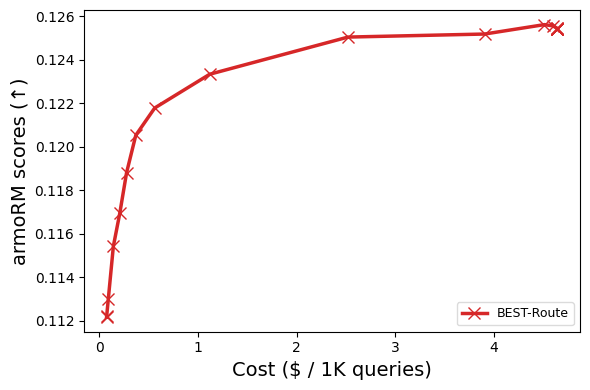

In [7]:
fig = plt.figure(figsize=(6, 4))
plt.style.use('default')

candidate_model_pair_cost_list = []
test_data = load_sample('data/hybridllm_dataset_armoRM_ourRM_bo5_ALL_token_num_test.jsonl')
# this candidate_model_list should be consistent with the "--candidate_model" argument in the training script
candidate_model_list = ['gpt-35-turbo', 'llama-31-8b', 'mistral-7b', 'mistral-8x7b', 'phi-3-medium', 'phi-3-mini', 'gpt-4o']

# maxtrix-of-router
results_path = f'outputs/best_route_bo5_test_run/'
all_labels = torch.load(os.path.join(results_path, "labels.pt"), weights_only=False).squeeze(2)[..., 0]
all_predictions = torch.load(os.path.join(results_path, "predictions.pt"), weights_only=False)
all_cost = []

for d in test_data:
    cost = []
    for candidate_model in candidate_model_list:
        if candidate_model == 'gpt-4o':
            for c in d['candidates']:
                if c['model'] == f'{candidate_model}_ourRM_bo1':
                    cost.append(c['token_num_prompt'] *
                                    model2prompt_cost[candidate_model] +
                                    c['token_num_responses'] *
                                    model2output_cost[candidate_model])
        else:
            for bon in range(1, bon + 1):
                for c in d['candidates']:
                    if c['model'] == f'{candidate_model}_ourRM_bo{bon}':
                        cost.append(c['token_num_prompt'] *
                                        model2prompt_cost[candidate_model] +
                                        c['token_num_responses'] *
                                        model2output_cost[candidate_model])
    all_cost.append(cost)

plot_matrix_of_router(all_labels, all_predictions, all_cost)

plt.xlabel("Cost ($ / 1K queries)", fontsize=14)
plt.ylabel("armoRM scores (↑)", fontsize=14)
plt.tight_layout()
plt.legend(loc='lower right', fontsize=9, framealpha=0.7)
plt.show()